# Features de TextMining:

---------------------------------

### Importando dependências

!pip install streamlit-aggrid --user

In [76]:
import os
import sys
import re
import datetime
import dateutil

sys.path.insert(0,os.path.dirname(os.getcwd()))
sys.path.insert(0,os.path.join(os.getcwd(),'grobid'))
sys.path.insert(0,os.getcwd())

import numpy as np
import pandas as pd

from grobid import grobid_client
import grobid_tei_xml
from grobid_to_dataframe import grobid_cli, xmltei_to_dataframe

import plotly

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from pyvis.network import Network

!pip install nltk --upgrade

!pip install gensim --upgrade

!pip install spacy --upgrade

!pip install stanford-corenlp --upgrade

!pip install corenlp --upgrade

!pip install textblob --upgrade

!pip install transformers --upgrade

!pip install pyvis

In [77]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------------------------

### Comandos Docker

docker run -t --rm --init -p 8080:8070 -p 8081:8071 --memory="9g" lfoppiano/grobid:0.7.0

docker run -t --rm --init -p 8080:8070 -p 8081:8071 lfoppiano/grobid:0.6.2

pip install grobid-tei-xml

### Definindo variáveis e caminhos

In [78]:
path = os.path.dirname(os.getcwd())
path_input = os.path.join(path,'artifacts','articles','ml_material','teste')

---------------------------------

### Funções para execução em batch

In [79]:
def get_path(path_input_path):
    """"""
    if os.path.exists(path_input_path):
        return path_input_path
    
    return os.getcwd()


def batch_process_path(path_input_path, n_workers=2,
                       check_cache=True,
                       cache_folder_name='summarticles_cache',
                       config_path="./grobid/config.json"):
    
    """"""
    
    gcli = grobid_cli(config_path=config_path)
    result_batch = gcli.process_pdfs(input_path=path_input_path,
                                     check_cache=check_cache,
                                     cache_folder_name=cache_folder_name,
                                     n_workers=n_workers,
                                     service="processFulltextDocument",
                                     generateIDs=True,
                                     include_raw_citations=True,
                                     include_raw_affiliations=True,
                                     consolidate_header=False,
                                     consolidate_citations=False,
                                     tei_coordinates=False,
                                     segment_sentences=True,
                                     verbose=True)
    return result_batch


def get_dataframes(result_batch):
    
    """"""
    
    xml_to_df = xmltei_to_dataframe()
    dict_dfs, dic_errors = xml_to_df.get_dataframe_articles(result_batch)
    
    return dict_dfs, dic_errors


def files_path(path):
    list_dir = os.listdir(path)
    files = []
    for file in list_dir:
        if os.path.isfile(os.path.join(path,file)):
            files.append(os.path.join(path,file))
    return files

In [80]:
def run_batch_process(path_input, n_workers=6, check_cache=True, 
                      cache_folder_name='summarticles_cache', 
                      config_path="./grobid/config.json"):

    dict_exec = {'path':path_input}
    dict_exec['start_datetime'] = datetime.datetime.now()
    
    # path_input = os.path.join(path,'artifacts','test_article')
    config_path = os.path.join(os.getcwd(),'grobid','config.json')
    dict_exec['grobid_config'] = config_path
    
    gcli = grobid_client.GrobidClient(config_path=config_path, check_server=False)
    
    dict_exec['files'] = gcli.get_input_files(path_input)
    dict_exec['num_files'] = len(dict_exec['files'])
    dict_exec['n_workers'] = n_workers
    
    path_input_path = get_path(path_input)
    result_batch = batch_process_path(path_input_path, n_workers=dict_exec['n_workers'], check_cache=check_cache)
    dict_dfs, dic_errors = get_dataframes(result_batch)
    
    gcli.save_xmltei_files(result_batch, input_folder_path, cache_folder_name=cache_folder_name)
    
    dict_exec['end_datetime'] = datetime.datetime.now()
    dict_exec['time_exec_sec'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    dict_exec['time_exec_min'] = (dict_exec['end_datetime']-dict_exec['start_datetime']).seconds
    
    return dict_dfs, dict_exec, dic_errors

In [81]:
input_folder_path = r"""C:\Users\vierb\OneDrive\Área de Trabalho\Projetos\PGC\artifacts\articles\ml_material"""

In [82]:
%%time
dict_dfs, dict_exec, dic_errors = run_batch_process(path_input=input_folder_path, 
                                                    n_workers=10, 
                                                    check_cache=True, 
                                                    cache_folder_name='summarticles_cache', 
                                                    config_path="./grobid/config.json")

GROBID server is up and running
587 files to process in current batch
[Input Files] 587
[Cache Files] 587
In the end, we have: 0  new files to process!
And we have : 587  files to back from cache!
Processed articles: 581
Number articles with errors: 6
Wall time: 25.3 s


In [8]:
print(dict_exec.keys())

dict_keys(['path', 'start_datetime', 'grobid_config', 'files', 'num_files', 'n_workers', 'end_datetime', 'time_exec_sec', 'time_exec_min'])


In [9]:
dic_errors

{'number_article_error': 6,
 'list_article_error': [{'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.110167.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\advs.201903667.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\s41578-021-00351-7.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\OneDrive\\Área de Trabalho\\Projetos\\PGC\\artifacts\\articles\\ml_material\\j.commatsci.2020.110166.pdf',
   'error': ValueError,
   'error_text': 'If using all scalar values, you must pass an index'},
  {'file': 'C:\\Users\\vierb\\On

In [10]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,DB8D8429C38703C340A65C2BEE553057,02484B814DFB99BFC7284F0A29BAE85A,04D06A6CDDBE1FF7A3DD057F33C0D8C2
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:10:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgement This work was supported financ...,Acknowledgements The authors gratefully acknow...
abstract,Mass spectrometry is a widespread approach use...,Materials properties such as defect diffusion ...,Ni-Ti-based shape memory alloys (SMAs) have fo...
body,INTRODUCTION Mass spectrometry is a widespread...,"Introduction Many dynamic phenomena, such as t...",Introduction Shape memory alloys (SMAs) of nic...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [11]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,DB8D8429C38703C340A65C2BEE553057,02484B814DFB99BFC7284F0A29BAE85A,04D06A6CDDBE1FF7A3DD057F33C0D8C2
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,NaN,NaN,NaN
title_head,Machine-learning-enhanced time-of-flight mass ...,Computational Materials Science,Combinatorial Synthesis and High-Throughput Ch...
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [12]:
dict_dfs['df_doc_authors'].head(3).T

pdf_md5,DB8D8429C38703C340A65C2BEE553057,DB8D8429C38703C340A65C2BEE553057,DB8D8429C38703C340A65C2BEE553057
full_name_author,Ye Wei,Srinivas Rama,Varanasi
given_name_author,Ye,Srinivas,NaN
middle_name_author,NaN,NaN,NaN
surname_author,Wei,Rama,Varanasi
email_author,y.wei@mpie.de,NaN,NaN
orcid_author,NaN,NaN,NaN
institution_author,NaN,NaN,NaN
department_author,Max-Planck-Institut f€ ur Eisenforschung,NaN,Max-Planck-Institut f€ ur Eisenforschung
laboratory_author,NaN,NaN,NaN
addr_line_author,"Max-Planck-Strasse 1, 40237 D€ usseldorf",NaN,"Max-Planck-Strasse 1, 40237 D€ usseldorf"


In [13]:
dict_dfs['df_doc_citations'].head(5)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
DB8D8429C38703C340A65C2BEE553057,0,b0,"Wolff, M.M., and Stephens, W.E. (1953). A puls...",1953,A pulsed mass spectrometer with time dispersion,NaN,NaN,Rev. Sci. Instr,NaN,NaN,...,616,617,NaN,10.1063/1.1770801,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,1,b1,"Maher, S., Jjunju, F., and Taylor, S. (2015). ...",2015,Colloquium : 100 years of mass spectrometry: p...,NaN,NaN,Rev. Mod. Phys,NaN,NaN,...,113,135,NaN,10.1103/RevModPhys.87.113,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,2,b2,"Sulzer, P., Petersson, F., Agarwal, B., Becker...",2012,Proton transfer reaction mass spectrometry and...,NaN,NaN,Anal. Chem,NaN,NaN,...,4161,4166,NaN,10.1021/ac3004456,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,3,b3,"Pedersen, S., Herek, J.L., and Zewail, A.H. (1...",1994,"The validity of the ""diradical"" hypothesis: di...",NaN,NaN,Science,NaN,NaN,...,1359,1364,NaN,10.1126/science.266.5189.1359.eprint,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,4,b4,"Tanaka, K., Waki, H., Ido, Y., Akita, S., Yosh...",1988,Protein and polymer analyses up to m/z 100 000...,NaN,NaN,Rapid Commun. Mass Spectrom,NaN,NaN,...,151,153,NaN,10.1002/rcm.1290020802,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
dict_dfs['df_doc_authors_citations'].head(5)

,id,index,full_name_citation,given_name_citation,middle_name_citation,surname_citation,email_citation,orcid_citation,institution_citation,department_citation,laboratory_citation,addr_line_citation,post_code_citation,settlement_citation,country_citation
pdf_md5,,,,,,,,,,,,,,,
DB8D8429C38703C340A65C2BEE553057,b0,0,M M Wolff,M,M,Wolff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,b0,0,W E Stephens,W,E,Stephens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,b1,1,S Maher,S,NaN,Maher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,b1,1,F Jjunju,F,NaN,Jjunju,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DB8D8429C38703C340A65C2BEE553057,b1,1,S Taylor,S,NaN,Taylor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------

### Trabalhando no tratamento do texto

!pip install pytorch --upgrade

!pip install tensorflow --upgrade --user

In [83]:
import nltk
import spacy
import corenlp
import textblob
import gensim
#import transformers

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vierb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

--------------------------------

Estudando a distribuição de caracteres especiais:

In [17]:
list_chars = []
for id,row in dict_dfs['df_doc_info'].iterrows():
    for c in row['raw_data']:
        list_chars.append(c)
        
df_counts = pd.DataFrame({'chars':pd.value_counts(list_chars).index.tolist(),'counts':pd.value_counts(list_chars).tolist()})
df_counts = df_counts.sort_values(by='counts',ascending=False)

import plotly.express as px
fig = px.bar(df_counts.head(20), x='chars', y='counts')
fig.show()

In [18]:
df_counts.sort_values(by='counts',ascending=False).tail(30)

,chars,counts
741,𝑭,1
740,𝒛,1
739,݊,1
742,⌊,1
749,ቀ,1
760,ℏ,1
726,⑥,1
750,𝐨,1
752,𝐧,1
753,𝐪,1


--------------------------------

Tratando texto:

In [84]:
def text_tokenize(text, language='english', preserve_line=False):
    return nltk.tokenize.word_tokenize(text, language=language, preserve_line=preserve_line)

def clean_text_regex(words_list, regex="[^a-zA-Z]+", replace='', min_word_len=1):
    """Testado em https://regex101.com/"""
    new_words = []
    for word in words_list:
        word = re.sub(regex, replace, word)
        if len(word) > min_word_len:
            new_words.append(word)
    return new_words

def remove_stopwords(words_list, stopwords_list):
    """"""
    new_words = []
    for word in words_list:
        if word not in stopwords_list:
            new_words.append(word)
    return new_words

def lemmatizer(words_list):
    """"""
    obj_lemmatizer = nltk.stem.WordNetLemmatizer()
    words_lemma = []
    for word in words_list:
        words_lemma.append(obj_lemmatizer.lemmatize(word,pos=nltk.corpus.wordnet.VERB))
    return words_lemma

def stem_text(words_list):
    """"""
    p_stem = nltk.stem.PorterStemmer()
    words_stem = []
    for word in words_list:
        words_stem.append(p_stem.stem(word))
    return words_stem

In [85]:
def text_prep(text, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, text_lower=False, stopwords_list=[], language='english',
              preserve_line=False, regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1):
    
    """Text preparation."""
    
    text_preparation = text_tokenize(text, language=language, preserve_line=preserve_line)
    if clean_text:
        text_preparation = clean_text_regex(words_list=text_preparation,
                                            regex=regex_chars_clean,
                                            replace=replace_chars_clean,
                                            min_word_len=min_word_len)
    if stopwords_remove:
        text_preparation = remove_stopwords(words_list=text_preparation,
                                            stopwords_list=stopwords_list)
    if exec_lemmatizer:
        text_preparation = lemmatizer(words_list=text_preparation)
    if exec_stem:
        text_preparation = stem_text(words_list=text_preparation)
    text_preparation = ' '.join(text_preparation)
    if text_lower:
        text_preparation = text_preparation.lower()
    return text_preparation

In [86]:
def text_prep_column(colum_df):
    """"""
    f_prep_text = lambda text_data: text_prep(text=text_data, clean_text=True, stopwords_remove=True, exec_lemmatizer=True, exec_stem=False, 
                                            stopwords_list=nltk.corpus.stopwords.words('english'), language='english', preserve_line=False,
                                            regex_chars_clean="[^a-zA-Z]+", replace_chars_clean='', min_word_len=1, text_lower=True)
    colum_df = colum_df.apply(lambda e: e if pd.isna(e) else f_prep_text(e))
    return colum_df

In [22]:
dict_dfs['df_doc_info'].abstract.iat[0]

"Mass spectrometry is a widespread approach used to work out what the constituents of a material are. Atoms and molecules are removed from the material and collected, and subsequently, a critical step is to infer their correct identities based on patterns formed in their mass-to-charge ratios and relative isotopic abundances. However, this identification step still mainly relies on individual users' expertise, making its standardization challenging, and hindering efficient data processing. Here, we introduce an approach that leverages modern machine learning technique to identify peak patterns in time-of-flight mass spectra within microseconds, outperforming human users without loss of accuracy. Our approach is cross-validated on mass spectra generated from different time-of-flight mass spectrometry (ToF-MS) techniques, offering the ToF-MS community an open-source, intelligent mass spectra analysis."

In [23]:
text_prep(text=dict_dfs['df_doc_info'].abstract.iat[0],
          clean_text=True,
          stopwords_remove=True,
          exec_lemmatizer=True,
          exec_stem=False,
          text_lower=True,
          stopwords_list=nltk.corpus.stopwords.words('english'),
          language='english',
          preserve_line=False,
          regex_chars_clean="[^a-zA-Z]+",
          replace_chars_clean='',
          min_word_len=1)

'mass spectrometry widespread approach use work constituents material atoms molecules remove material collect subsequently critical step infer correct identities base pattern form masstocharge ratios relative isotopic abundances however identification step still mainly rely individual users expertise make standardization challenge hinder efficient data process here introduce approach leverage modern machine learn technique identify peak pattern timeofflight mass spectra within microseconds outperform human users without loss accuracy our approach crossvalidated mass spectra generate different timeofflight mass spectrometry tofms techniques offer tofms community opensource intelligent mass spectra analysis'

In [24]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,DB8D8429C38703C340A65C2BEE553057,02484B814DFB99BFC7284F0A29BAE85A,04D06A6CDDBE1FF7A3DD057F33C0D8C2
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:10:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgement This work was supported financ...,Acknowledgements The authors gratefully acknow...
abstract,Mass spectrometry is a widespread approach use...,Materials properties such as defect diffusion ...,Ni-Ti-based shape memory alloys (SMAs) have fo...
body,INTRODUCTION Mass spectrometry is a widespread...,"Introduction Many dynamic phenomena, such as t...",Introduction Shape memory alloys (SMAs) of nic...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


In [87]:
dict_dfs['df_doc_info']['acknowledgement_prep'] = text_prep_column(dict_dfs['df_doc_info']['acknowledgement'])
dict_dfs['df_doc_info']['abstract_prep'] = text_prep_column(dict_dfs['df_doc_info']['abstract'])
dict_dfs['df_doc_info']['body_prep'] = text_prep_column(dict_dfs['df_doc_info']['body'])

In [26]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,DB8D8429C38703C340A65C2BEE553057,02484B814DFB99BFC7284F0A29BAE85A,04D06A6CDDBE1FF7A3DD057F33C0D8C2
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:11:00,2022-05-15 02:09:00,2022-05-15 02:10:00
language_code,en,en,en
acknowledgement,NaN,Acknowledgement This work was supported financ...,Acknowledgements The authors gratefully acknow...
abstract,Mass spectrometry is a widespread approach use...,Materials properties such as defect diffusion ...,Ni-Ti-based shape memory alloys (SMAs) have fo...
body,INTRODUCTION Mass spectrometry is a widespread...,"Introduction Many dynamic phenomena, such as t...",Introduction Shape memory alloys (SMAs) of nic...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------------

Word Cloud:

!pip install wordcloud

In [27]:
from wordcloud import WordCloud
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sb

In [28]:
def word_cloud(documents, width=1000, height=200, collocations=True, background_color='white'):
    """Create and plot a wordcloud from documents list."""
    objWC = WordCloud(collocations=collocations, background_color=background_color, width=width, height=height)
    text = ' '.join([ ' ' if pd.isna(t) else t for t in documents])
    objWC = objWC.generate_from_text(text)
    ax = plt.imshow(objWC)
    plt.axis("off")
    plt.show()

In [29]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

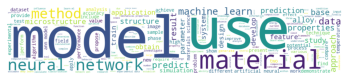

In [30]:
word_cloud(documents, width=1000, height=200, collocations=True, background_color='white')

In [46]:
documents_abs = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()
documents_body = dict_dfs['df_doc_info']['body_prep'].fillna(' ').tolist()
documents_all_text = [' '.join([abst, body]) for abst, body in zip(documents_abs, documents_body)]

In [51]:
def text_statistics(text):
    
    """"""
    
    dictStats = {}
    dictStats['num_chars'] = len(text)
    list_tokens = text_tokenize(str(text))
    dictStats['num_words'] = len(list_tokens)
    dictStats['num_words_unique'] = len(set(list_tokens))
    
    len_words = pd.Series([len(w) for w in list_tokens]).describe().to_dict()
    dictStats['mean_lenght_word'] = len_words['mean']
    dictStats['min_lenght_word'] = len_words['min']
    dictStats['max_lenght_word'] = len_words['max']
    dictStats['std_lenght_word'] = len_words['std']
    dictStats['first_quartile_lenght_word'] = len_words['25%']
    dictStats['second_quartile_median_lenght_word'] = len_words['50%']
    dictStats['third_quartile_lenght_word'] = len_words['75%']
    
    return dictStats

In [55]:
df_articles_stats = pd.DataFrame(list(map(lambda e: text_statistics(e), documents_all_text)))

In [66]:
token_text = text_tokenize(' '.join(documents_all_text))

In [67]:
words_freq = pd.value_counts(token_text)
words_freq = pd.DataFrame(words_freq,columns=['frequency'])
words_freq.index.name = 'word'
words_freq = words_freq.reset_index()

words_freq.head()

,word,word frequency
0,the,31896
1,model,26780
2,use,22826
3,fig,17820
4,data,15962


In [73]:
list_bigrams = list(nltk.bigrams(token_text))
bigram_freq = pd.value_counts(list_bigrams)
df_bigram = pd.DataFrame(bigram_freq, columns=['frequency'])
df_bigram.index.name = 'bigram'
df_bigram = df_bigram.reset_index()

df_bigram.head()

,bigram,frequency
0,"(neural, network)",4955
1,"(fig, fig)",4054
2,"(et, al)",3844
3,"(machine, learn)",3525
4,"(show, fig)",2442


In [74]:
list_trigam = list(nltk.trigrams(token_text))
trigam_freq = pd.value_counts(list_trigam)
df_trigram = pd.DataFrame(trigam_freq, columns=['frequency'])
df_trigram.index.name = 'trigram'
df_trigram = df_trigram.reset_index()

df_trigram.head()

,trigram,frequency
0,"(none, none, none)",1229
1,"(artificial, neural, network)",1019
2,"(neural, network, model)",578
3,"(machine, learn, model)",561
4,"(show, fig, the)",465


In [72]:
pd.value_counts(list_bigrams)

(mass, spectrometry)          1
(spectrometry, widespread)    1
dtype: int64

In [56]:
df_articles_stats.head()

,num_chars,num_words,num_words_unique,mean_lenght_word,min_lenght_word,max_lenght_word,std_lenght_word,first_quartile_lenght_word,second_quartile_median_lenght_word,third_quartile_lenght_word
0,29136,3980,1167,6.320854,2.0,54.0,2.967922,4.0,6.0,8.0
1,24948,3310,933,6.537462,2.0,22.0,2.930383,4.0,6.0,9.0
2,15780,1941,678,7.130345,2.0,28.0,3.443058,4.0,7.0,10.0
3,10137,1429,428,6.094472,2.0,16.0,2.931793,4.0,6.0,8.0
4,21687,2937,930,6.384406,2.0,22.0,3.158560,4.0,6.0,8.0


In [88]:
dict_agg_stats = {}

# Chars
dict_agg_stats['num_total_chars'] = df_articles_stats['num_chars'].sum()
dict_agg_stats['num_mean_chars'] = df_articles_stats['num_chars'].mean()
dict_agg_stats['num_min_chars'] = df_articles_stats['num_chars'].min()
dict_agg_stats['num_max_chars'] = df_articles_stats['num_chars'].max()

# num_words
dict_agg_stats['num_total_words'] = df_articles_stats['num_words'].sum()
dict_agg_stats['num_mean_words'] = df_articles_stats['num_words'].mean()
dict_agg_stats['num_min_words'] = df_articles_stats['num_words'].min()
dict_agg_stats['num_max_chars'] = df_articles_stats['num_words'].max()

# num_words_unique
dict_agg_stats['num_total_words_unique'] = df_articles_stats['num_words'].sum()
dict_agg_stats['num_mean_words_unique'] = df_articles_stats['num_words'].mean()
dict_agg_stats['num_min_words_unique'] = df_articles_stats['num_words'].min()
dict_agg_stats['num_max_chars_unique'] = df_articles_stats['num_words'].max()

# mean_lenght_word
dict_agg_stats['mean_length_words'] = df_articles_stats['mean_lenght_word'].mean()

# mean_lenght_word
dict_agg_stats['lexical_density'] = dict_agg_stats['num_mean_words']/dict_agg_stats['num_mean_words_unique']
    

--------------------------------

Criando BOW e TFIDF:

In [89]:
documents = dict_dfs['df_doc_info']['abstract_prep'].fillna(' ').tolist()

In [90]:
obj_bow = CountVectorizer(encoding="utf-8",
                          stop_words="english",
                          strip_accents="ascii",
                          lowercase=True, 
                          preprocessor=None,
                          tokenizer=None,
                          token_pattern=r"""(?u)\b\w\w+\b""",
                          ngram_range=(1,2), # Unigram and bigram
                          analyzer="word",
                          max_df=1.0,
                          min_df=2, # May have at least 2 frequency
                          max_features=None, 
                          vocabulary= None, 
                          binary=False, 
                          dtype=np.int64)

obj_tfidf = TfidfVectorizer(encoding="utf-8",
                            stop_words="english",
                            strip_accents="ascii",
                            lowercase=True, 
                            preprocessor=None,
                            tokenizer=None,
                            token_pattern=r"""(?u)\b\w\w+\b""",
                            ngram_range=(1,2), # Unigram and bigram
                            analyzer="word",
                            max_df=1.0,
                            min_df=2, # May have at least 2 frequency
                            max_features=None, 
                            vocabulary= None, 
                            binary=False, 
                            dtype=np.float64, 
                            norm='l2', 
                            use_idf=True, 
                            smooth_idf=True, 
                            sublinear_tf=False)

obj_bow = obj_bow.fit(raw_documents=documents)
bow_matrix = obj_bow.transform(documents)

obj_tfidf = obj_tfidf.fit(raw_documents=documents)
tfidf_matrix = obj_tfidf.transform(documents)

bow_matrix = bow_matrix.todense()
tfidf_matrix = tfidf_matrix.todense()

df_bow = pd.DataFrame(bow_matrix, columns=obj_bow.get_feature_names())
df_tfidf = pd.DataFrame(tfidf_matrix, columns=obj_tfidf.get_feature_names())

In [37]:
df_bow.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_tfidf.head(3)

,aa,aa aluminum,aare,ab,ab initio,abaqus,abilities,ability,ability feasible,ability gfa,...,zirconia,zn,zn alloy,zn coat,zncl,zone,zone fz,zr,zr hf,zro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------

Trabalhando com a similaridade de Cosseno:

In [91]:
cos_bow_sim = cosine_similarity(df_bow, df_bow)
cos_tfidf_sim = cosine_similarity(df_tfidf, df_tfidf)

df_cos_bow_sim = pd.DataFrame(cos_bow_sim,
                              columns=dict_dfs['df_doc_info'].index.tolist(),
                              index=dict_dfs['df_doc_info'].index.tolist())

df_cos_tfidf_sim = pd.DataFrame(cos_tfidf_sim,
                                columns=dict_dfs['df_doc_info'].index.tolist(),
                                index=dict_dfs['df_doc_info'].index.tolist())

In [40]:
df_cos_bow_sim.head()

,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396,5738B3337DA48C2F221412A93F30180E,B1E7E29A38EBB67A01DFD873E253377E,429027A5E0C80C54253970FC06414C81,CBC106ACF2BDF9FE6F17530F49C36090,4E4F283904C6A35D1630F240C826B4BB,F93B8E7FE9948A2FDBD600CE985ADCF8,4B56666A82B4FB26D98E4EF7A711800A,...,3CAFC85AAD32F0D628DBD376075428C2,B2B67BF935077AD2834DB38A03B5DC3D,51F9C87ED1F9220C139778431021D5C6,C44D174BD42FBC6C8D7AC07AF77152CA,40BE015C8EF3233DC5227C97AC7866B3,C1B5CAAD4EAA907B625B74BB9EB976AE,90DD95B6ABEF04FFA4B5D442FE93CE0C,B26F1A776393CDDB73667F67BE74FB1C,31D37B5FDA2545B074F72106E06F7332,95502724D7D6CFDAEBD7F3F7358BF4FC
6626851C6FCB1527706C9BEDC03D12FF,1.000000,0.090935,0.022018,0.116672,0.193398,0.120499,0.303521,0.119582,0.068654,0.000000,...,0.143168,0.171499,0.117192,0.161739,0.110044,0.088930,0.126589,0.296869,0.057582,0.036530
92D61639BAD7D4AD564A8CBD7E0E2D80,0.090935,1.000000,0.007166,0.101923,0.084297,0.042354,0.062562,0.110610,0.080437,0.000000,...,0.111191,0.027907,0.059056,0.080883,0.034381,0.118401,0.050354,0.102562,0.099948,0.117188
16084FC6B5C25AF4A5F11957425A9396,0.022018,0.007166,1.000000,0.000000,0.000000,0.007217,0.010099,0.000000,0.010279,0.027067,...,0.024359,0.008559,0.033961,0.005906,0.006591,0.000000,0.007020,0.006838,0.023949,0.023440
5738B3337DA48C2F221412A93F30180E,0.116672,0.101923,0.000000,1.000000,0.051914,0.084531,0.122515,0.063073,0.051602,0.022646,...,0.077445,0.064450,0.071035,0.069183,0.038598,0.151911,0.064605,0.108705,0.052096,0.071909
B1E7E29A38EBB67A01DFD873E253377E,0.193398,0.084297,0.000000,0.051914,1.000000,0.050937,0.289868,0.144109,0.188637,0.000000,...,0.149005,0.100687,0.133169,0.180650,0.052719,0.051261,0.211401,0.212368,0.094659,0.062502


In [41]:
df_cos_tfidf_sim.head()

,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396,5738B3337DA48C2F221412A93F30180E,B1E7E29A38EBB67A01DFD873E253377E,429027A5E0C80C54253970FC06414C81,CBC106ACF2BDF9FE6F17530F49C36090,4E4F283904C6A35D1630F240C826B4BB,F93B8E7FE9948A2FDBD600CE985ADCF8,4B56666A82B4FB26D98E4EF7A711800A,...,3CAFC85AAD32F0D628DBD376075428C2,B2B67BF935077AD2834DB38A03B5DC3D,51F9C87ED1F9220C139778431021D5C6,C44D174BD42FBC6C8D7AC07AF77152CA,40BE015C8EF3233DC5227C97AC7866B3,C1B5CAAD4EAA907B625B74BB9EB976AE,90DD95B6ABEF04FFA4B5D442FE93CE0C,B26F1A776393CDDB73667F67BE74FB1C,31D37B5FDA2545B074F72106E06F7332,95502724D7D6CFDAEBD7F3F7358BF4FC
6626851C6FCB1527706C9BEDC03D12FF,1.000000,0.035407,0.012118,0.024396,0.066446,0.035486,0.072909,0.046670,0.019630,0.000000,...,0.027683,0.047404,0.040835,0.044660,0.026895,0.034284,0.031078,0.084208,0.038910,0.005897
92D61639BAD7D4AD564A8CBD7E0E2D80,0.035407,1.000000,0.005487,0.029734,0.041781,0.013704,0.034504,0.050845,0.053624,0.000000,...,0.030849,0.010124,0.025145,0.033811,0.011037,0.033124,0.022108,0.060325,0.048056,0.046247
16084FC6B5C25AF4A5F11957425A9396,0.012118,0.005487,1.000000,0.000000,0.000000,0.002648,0.007247,0.000000,0.004259,0.006341,...,0.006243,0.006124,0.013130,0.004332,0.001916,0.000000,0.003731,0.005572,0.014496,0.016431
5738B3337DA48C2F221412A93F30180E,0.024396,0.029734,0.000000,1.000000,0.021092,0.024574,0.036573,0.023161,0.023036,0.009551,...,0.014043,0.021172,0.031424,0.025200,0.011500,0.053529,0.017530,0.024773,0.020560,0.026929
B1E7E29A38EBB67A01DFD873E253377E,0.066446,0.041781,0.000000,0.021092,1.000000,0.014724,0.079616,0.045229,0.059002,0.000000,...,0.025208,0.038432,0.064509,0.089675,0.012790,0.011673,0.040082,0.074529,0.077657,0.030926


Gerando grafo de similaridade de cosseno:

In [92]:
def filter_sim_matrix(matrix, percentil="75%", value_min=0, value_max=1):
    """"""
    list_elements = []
    for colum in df_cos_tfidf_sim.columns.tolist():
        list_elements += df_cos_tfidf_sim[colum].tolist()
    sim_describe = pd.Series(list_elements).describe(percentiles=np.arange(0, 1, 0.001))
    del list_elements
    
    filter_matrix = sim_describe[percentil]
    
    list_filter = []
    for i,row in matrix.iterrows():
        for j in row.index:
            value = matrix.loc[i,j]
            logic_filter = value>=filter_matrix and value>value_min and value<value_max
            if not pd.isna(value) and logic_filter:
                dictCell = {"doc_a":i,"doc_b":j,'value':matrix.loc[i,j]}
                list_filter.append(dictCell)
    df_maxtrix_filter = pd.DataFrame(list_filter)
    del list_filter
    
    return df_maxtrix_filter

In [93]:
def make_sim_graph(matrix,
                   node_data,
                   source_column="doc_a",
                   to_column="doc_b",
                   value_column="value",
                   height="500px",
                   width="500px",
                   directed=False,
                   notebook=False,
                   bgcolor="#ffffff",
                   font_color=False,
                   layout=None,
                   heading="",
                   path_graph="./", 
                   name_file="graph.html"):
    """"""
    graph = Network(height=height,
                    width=width,
                    directed=directed,
                    notebook=notebook,
                    bgcolor=bgcolor,
                    font_color=font_color,
                    layout=layout,
                    heading=heading)

    for i, row in node_data.iterrows():
        
        article_id = str(row['pdf_md5'])
        article_title = str(row['title_head'])
        article_abstract_short = str(row['abstract_short'])
        article_date = str(row['date_head'])
        article_number_authors = str(row['author_count'])
        article_number_citations = str(row['citation_count'])
        article_doi = str(row['doi_head'])
        article_file_name = str(row['file_name'])
        article_file_path = str(row['file'])
        
        title_html = f"""Article Title:{article_title}
                         Article Date:{article_date}
                         Article Number Authors:{article_number_authors}
                         Article Number Citations:{article_number_citations}
                         Article DOI:{article_doi}
                         Article File Name:{article_file_name}"""
        
        graph.add_node(n_id=article_id, 
                       label=f"Node ID: {str(article_id)[0:4]}", 
                       borderWidth=1, 
                       borderWidthSelected=2, 
                       #brokenImage="url", 
                       #group="a", 
                       #hidden=False, 
                       #image="url", 
                       #labelHighlightBold=True, 
                       #level=1, 
                       #mass=1, 
                       #physics=True,
                       shape="dot", # image, circularImage, diamond, dot, star, triangle, triangleDown, square and icon
                       size=1, 
                       title=title_html,  
                       #x=0.5, 
                       #y=1.0)
                       value=1)
        
    for i,row in matrix.iterrows():
        
        graph.add_edge(source=row[source_column],
                       to=row[to_column],
                       value=round(row[value_column],1),
                       title=row[value_column])
                       #width=row['value'],
                       #arrowStrikethrough=False,
                       #physics=False,
                       #hidden=False)
    
    graph.force_atlas_2based(gravity=-50,
                             central_gravity=0.01,
                             spring_length=360,
                             spring_strength=0.08,
                             damping=0.4,
                             overlap=0)
    
    graph.save_graph(os.path.join(path_graph, name_file))
    graph.show_buttons(filter_=['physics'])
    graph.show(name_file)
    return graph   

In [94]:
df_cos_bow_sim_filter = filter_sim_matrix(df_cos_bow_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_bow_sim_filter = df_cos_bow_sim_filter.nlargest(300,'value')

df_cos_tfidf_sim_filter = filter_sim_matrix(df_cos_tfidf_sim, percentil="99%", value_min=0, value_max=0.99)
df_cos_tfidf_sim_filter = df_cos_tfidf_sim_filter.nlargest(300,'value')

In [95]:
# Selecting head article data
cols_head = ['title_head', 'doi_head', 'date_head',]
head_data = dict_dfs['df_doc_head'].loc[:,cols_head].reset_index().copy()
head_data['title_head'] = head_data['title_head'].apply(lambda e: str(e)[0:50] + "..." if len(str(e)) > 50 else str(e))

# Selecting head article data
cols_info = ['abstract','file']
doc_info_data = dict_dfs['df_doc_info'].loc[:,cols_info].reset_index().copy()
doc_info_data['file_name'] = doc_info_data['file'].apply(lambda e: os.path.split(e)[-1])
doc_info_data['abstract_short'] = doc_info_data['abstract'].apply(lambda e: str(e)[0:20] + "..." if len(str(e)) > 20 else str(e))
doc_info_data.drop(labels=['abstract'], axis=1, inplace=True)

# Selecting authors information
authors_data = dict_dfs['df_doc_authors'].reset_index()
authors_data = authors_data.groupby(by=['pdf_md5'], as_index=False)['full_name_author'].count()
authors_data.rename(columns={'full_name_author':'author_count'}, inplace=True)

# Selecting citations information
citations_data = dict_dfs['df_doc_citations'].reset_index()
citations_data = citations_data.groupby(by=['pdf_md5'], as_index=False)['index_citation'].count()
citations_data.rename(columns={'index_citation':'citation_count'}, inplace=True)

nodes = list(set(df_cos_bow_sim_filter.doc_a.tolist()+df_cos_bow_sim_filter.doc_b.tolist()))
df_nodes = pd.DataFrame(nodes, columns=['pdf_md5'])

df_nodes = df_nodes.merge(head_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(doc_info_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(authors_data, how='left', on='pdf_md5')
df_nodes = df_nodes.merge(citations_data, how='left', on='pdf_md5')

In [96]:
df_cos_tfidf_sim_filter.head()

,doc_a,doc_b,value
228,7B2A25ACAC669EDBF3394FB82A804BE3,13EF01368C4B64913BAC3B6B06D855FF,0.892992
230,7B2A25ACAC669EDBF3394FB82A804BE3,1451EBDA3D877A66CD0810390DA1F79A,0.892992
342,3A05ADAA3D4DA1371BB14438393383D7,13EF01368C4B64913BAC3B6B06D855FF,0.892992
344,3A05ADAA3D4DA1371BB14438393383D7,1451EBDA3D877A66CD0810390DA1F79A,0.892992
393,758868295D04CA19FEEF7DBC78AB81A2,13EF01368C4B64913BAC3B6B06D855FF,0.892992


In [46]:
sim_graph = make_sim_graph(matrix=df_cos_bow_sim_filter,
                           node_data=df_nodes,
                           source_column="doc_a",
                           to_column="doc_b",
                           value_column="value",
                           height="1000px",
                           width="1000px",
                           directed=True,
                           notebook=False,
                           bgcolor="#ffffff",
                           font_color=False,
                           layout=None,
                           heading="",
                           path_graph="./", 
                           name_file="graph.html")

In [75]:
df_cos_bow_sim_filter.head()

NameError: name 'df_cos_bow_sim_filter' is not defined

In [47]:
dict_dfs.keys()

dict_keys(['df_doc_info', 'df_doc_head', 'df_doc_authors', 'df_doc_citations', 'df_doc_authors_citations'])

In [48]:
df_nodes.head(3).T

,0,1,2
pdf_md5,22D85DDA992554F017589484A42AC80E,018A6DCEA3374B0D9F6EBF279926BD10,314A5C0E6A8EEA4F2DC43EF27E1CC2BE
title_head,Deep Learning-based Discriminative Refocusing ...,Artificial neural network modified constitutiv...,Artificial neural network approach to predict ...
doi_head,10.1016/j.actamat.2021.116987,10.1016/j.msea.2021.141259,10.1016/j.commatsci.2011.01.015
date_head,NaN,2021-04-18,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
file_name,j.actamat.2021.116987.pdf,j.msea.2021.141259.pdf,j.commatsci.2011.01.015.pdf
abstract_short,This is a PDF file o...,To study the hot def...,Isothermal compressi...
author_count,6,6,5
citation_count,52,46,35


In [49]:
dict_dfs['df_doc_citations'].head(3)

,index_citation,id_citation,unstructured_citation,date_citation,title_citation,book_title_citation,series_title_citation,journal_citation,journal_abbrev_citation,publisher_citation,...,first_page_citation,last_page_citation,note_citation,doi_citation,pmid_citation,pmcid_citation,arxiv_id_citation,ark_citation,istex_id_citation,url_citation
pdf_md5,,,,,,,,,,,,,,,,,,,,,
6626851C6FCB1527706C9BEDC03D12FF,0,b0,National Science and Technology Council (U.S.)...,2011,Materials Genome Initiative for Global Competi...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6626851C6FCB1527706C9BEDC03D12FF,1,b1,"S. Curtarolo, et al., AFLOWLIB.ORG: A distribu...",2012,ORG: A distributed materials properties reposi...,NaN,NaN,Comput. Mater. Sci,NaN,NaN,...,227,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6626851C6FCB1527706C9BEDC03D12FF,2,b2,"A. Jain, et al., Commentary: the Materials Pro...",2013,Commentary: the Materials Project: A materials...,NaN,NaN,APL Mater,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_cos_bow_sim_filter.head(3).T

,160,161,929
doc_a,16084FC6B5C25AF4A5F11957425A9396,16084FC6B5C25AF4A5F11957425A9396,F552BCBA44563DB3A3286029363E21F2
doc_b,1451EBDA3D877A66CD0810390DA1F79A,13EF01368C4B64913BAC3B6B06D855FF,1451EBDA3D877A66CD0810390DA1F79A
value,0.95141,0.95141,0.95141


In [51]:
dict_dfs['df_doc_head'].head(3).T

pdf_md5,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396
index_head,NaN,NaN,NaN
id_head,NaN,NaN,NaN
unstructured_head,NaN,NaN,NaN
date_head,NaN,NaN,2020-05-01
title_head,Computational Materials Science,Investigation of the property hull for solid o...,Journal Pre-proof Deep Learning Analysis on Mi...
book_title_head,NaN,NaN,NaN
series_title_head,NaN,NaN,NaN
journal_head,NaN,NaN,NaN
journal_abbrev_head,NaN,NaN,NaN
publisher_head,NaN,NaN,NaN


In [52]:
dict_dfs['df_doc_info'].head(3).T

pdf_md5,6626851C6FCB1527706C9BEDC03D12FF,92D61639BAD7D4AD564A8CBD7E0E2D80,16084FC6B5C25AF4A5F11957425A9396
grobid_version,0.7.0,0.7.0,0.7.0
grobid_timestamp,2022-05-15 02:09:00,2022-05-15 02:09:00,2022-05-15 02:11:00
language_code,en,en,en
acknowledgement,Acknowledgements The work by PK and JCN is par...,Acknowledgment The authors would like to ackno...,Acknowledgements This work is supported by Chi...
abstract,The steady growth of online materials database...,Designing optimal microstructures for solid ox...,This is a PDF file of an article that has unde...
body,Introduction The use of machine learning in th...,Introduction Fuel cells (FCs) offer many advan...,Introduction A primary goal of materials scien...
annex,NaN,NaN,NaN
file,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...,C:\Users\vierb\OneDrive\Área de Trabalho\Proje...
status,status 200,status 200,status 200
raw_data,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<TEI x..."


--------------------------                             